# Imports and Flags
The boolean flags here are important to determine what runs

In [1]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import math
import gc
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from skorch.helper import predefined_split

isGoogleDrive = False
shouldImputeData = False
shouldRestoreImputer = False
isUsingMetadata = True
isUsingCNN = False
if isGoogleDrive:
    from google.colab import drive
    drive.mount('/content/drive')
else:
    workingDirectory = r'E:\Google Drive\University 17215286\Honours\Semester 1\COS 711 Artificial Intelligence II\Assignments\Assignment 3\Code'
    os.getcwd()
    os.chdir(workingDirectory)
    os.getcwd()
    train=pd.read_csv("./data/Train.csv")
    test_no_labels=pd.read_csv("./data/Test.csv")
    metadata_station=pd.read_csv("./data/airqo_metadata.csv")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from sklearn.datasets import make_classification
from skorch import NeuralNetClassifier
torch.manual_seed(7)

In [3]:
if isGoogleDrive:
    train = pd.read_csv("/content/drive/My Drive/COS 711 Assignment 3/data/Train.csv")
    test_no_labels = pd.read_csv("/content/drive/My Drive/COS 711 Assignment 3/data/Test.csv")
    metadata_station=pd.read_csv("./data/airqo_metadata.csv")

In [4]:
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [5]:
# covert features from string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test_no_labels[feature]=test_no_labels[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

In [6]:
train = train.drop(columns=['ID']) #no need for ID column
test_no_labels = test_no_labels.drop(columns=['ID']) #no need for ID column

## Segment the data to have a separate test set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_actual, test_actual = train_test_split(train, test_size=0.15, random_state=7) #default random shuffle
train = train_actual

In [9]:
print(train.shape)
print(test_actual.shape)

(13208, 8)
(2331, 8)


# Processing the training data
### Visualisation of missing data
The following cell plots some random examples of missing data given a feature_index and num_to_select

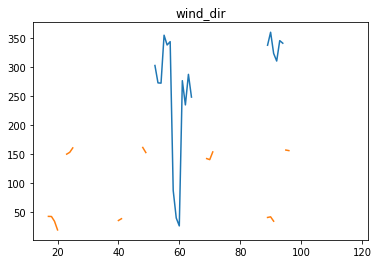

In [10]:
import random
feature_index =3
num_to_select = 2
list_vals = []
for index, row in train.iterrows():
    currFeature = row[features[feature_index]]
    if num_to_select == 0:
        break
    if(pd.Series(currFeature).isna().sum() > 0):
        if random.random() < 0.5:
            num_to_select -= 1
            list_vals.append(currFeature)
        
for l in list_vals:
    plt.plot(l)
plt.title(features[feature_index])
plt.show()

In [11]:
def dropRowsWithAnyNulls(df):
    for index, row in tqdm(df.iterrows()):
        for feature in features:
            if(pd.Series(row[feature]).isna().sum() > 0):
                df.drop(index, inplace= True, axis=0)
                break

### Creating a copy of the data set for Autoencoder imputation

In [12]:
if shouldImputeData:
    train_copy = train.copy() 

Remove nulls and generate training data for the autoencoder

In [13]:
if shouldImputeData:
    print(train_copy.shape)
    dropRowsWithAnyNulls(train_copy)
    print(train_copy.shape)

In [14]:
class AutoencoderImputer(nn.Module):
    def __init__(self, inputDim):
        super(AutoencoderImputer, self).__init__()
        
        self.inputDim = inputDim
        self.h1Dim = int(inputDim * (2 / 3))
        self.h2Dim = int(inputDim * (1 / 3))
        self.h3Dim = self.h1Dim
        
        self.bn1 = nn.BatchNorm1d(self.h1Dim)
        self.bn2 = nn.BatchNorm1d(self.h2Dim)
        self.bn3 = nn.BatchNorm1d(self.h3Dim)
        self.ln1 = nn.Linear(inputDim, self.h1Dim)
        self.ln2 = nn.Linear(self.h1Dim, self.h2Dim) 
        self.ln3 = nn.Linear(self.h2Dim, self.h3Dim) 
        self.ln4 = nn.Linear(self.h3Dim, self.inputDim) 

    def forward(self, t):
        t = F.relu(self.bn1(self.ln1(t)))
        t = F.relu(self.bn2(self.ln2(t)))
        t = F.relu(self.bn3(self.ln3(t)))
        t = F.relu(self.ln4(t))
        return t

#### Utility functions

In [15]:
def convertRowToFlatTensor(row):
    tens = torch.tensor([])
    for feature in features:
        tens = torch.cat((tens, torch.tensor(row[feature])), -1)
    return tens

def convertNullsToConst(tens):
    tens[tens != tens] = -1
    return tens

#### Dataset 

In [16]:
class ImputeDataset(Dataset):
    #The initialisation of this dataset generates the inputs using random nulls
    def __init__(self, trainingDataframe, testDataframe=None):
        tmp = []
        for index, row in trainingDataframe.iterrows():
            tens = convertRowToFlatTensor(row)
            tmp.append(tens)
            
        self.targets = tmp #targets are the non null tensors
        self.data = self.getNullifiedData(self.targets)
        if testDataframe is not None:
            self.augmentWithTestData(testDataframe)
        print("Initiated Dataset\n")
    
    def getNullifiedData(self, listOfCompleteTargets):
        inputList = []
        for example in listOfCompleteTargets:
            inputList.append(self.generateRandomNulls(example))
        return inputList
         
    def generateRandomNulls(self, example):
        totalNullsAdded = 0
        targetTensor = example.clone()
        numTimes = random.randint(1, 4)
        while numTimes > 0:
            indexToStartNulls = random.randint(0, 120) 
            numNullsToAdd = random.randint(1, 20)  
            while numNullsToAdd > 0 and indexToStartNulls < 121:
                for i in range(len(features)):
                    targetTensor[indexToStartNulls + i * 121] = -1
                numNullsToAdd -= 1
                indexToStartNulls += 1
            numTimes -= 1    
        return targetTensor
    
    def augmentWithTestData(self, dataframe):
        dropRowsWithAnyNulls(dataframe)
        tmp = []
        for index, row in dataframe.iterrows():
            tens = convertRowToFlatTensor(row)
            tmp.append(tens)
        nullified = self.getNullifiedData(tmp)
        self.data.extend(nullified)
        self.targets.extend(tmp)        
            
    def __getitem__(self, index):
        return (self.data[index], self.targets[index])
    
    def __len__(self):
        return len(self.data)

In [17]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    imputation_dataset = ImputeDataset(train_copy, test_no_labels) #preparing dataset with inputs containing random nulls and target outputss

In [18]:
from sklearn.datasets import make_regression
import skorch
from skorch import NeuralNet
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import cross_validate

autoencoder_regressor = NeuralNet(
    module=AutoencoderImputer,
    module__inputDim= 121*len(features),
    criterion=torch.nn.L1Loss,
    optimizer=torch.optim.Adam,
    max_epochs=1000,
    lr = 1e-3,
    device='cuda',
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5)]
)

In [19]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    autoencoder_regressor.fit(imputation_dataset)

#### Save the model

In [20]:
if shouldRestoreImputer == False and shouldImputeData == True: 
    autoencoder_regressor.save_params(f_params='autoencoder_imputer2.pkl')

#### Load the model

In [21]:
if shouldRestoreImputer == True and shouldImputeData == True: 
    autoencoder_regressor.initialize()  # This is important!
    autoencoder_regressor.load_params(f_params='autoencoder_imputer2.pkl')

#### Illustrate an imputation example

In [22]:
if shouldImputeData == True: 
    with torch.no_grad():
        inp = convertRowToFlatTensor(train.iloc[255])
        mask = inp != inp
        beforeNullsRemoved = inp.clone()
        inp = convertNullsToConst(inp)
        inp = torch.unsqueeze(inp, 0)
        res = autoencoder_regressor.predict(inp)
        res = res[0]
        toGraph = res
    #     for ind, truth in enumerate(mask):
    #         if truth:
    #             toGraph.append(res[ind])
    #         else:
    #             toGraph.append(np.nan)
        for i in range( int(len(beforeNullsRemoved) / 121)) :
            plt.plot(beforeNullsRemoved[(i * 121): ((i+1) * 121)], 'b-')
            plt.plot(toGraph[(i * 121): ((i+1) * 121)] , 'r--')
            plt.show()

### Filling in missing values
Use the autoencoder to fill in missing values

In [23]:
def shouldFillInMissingValues(row):
    for feature in features:
        sumOfNulls = pd.Series(row[feature]).isna().sum()
        if sumOfNulls > 60:
            return False
    return True

def getFeatureBucket(index):
    bucket =  int(index / 121) 
    for i in range(len(features)):
        if bucket == i:
            return features[i]
    return None

In [24]:
def imputeRow(row, model):
    inp = convertRowToFlatTensor(row)
    mask = inp != inp #find the nan values
    beforeNullsRemoved = inp.clone()
    inp = convertNullsToConst(inp)
    inp = torch.unsqueeze(inp, 0)
#     print(inp.shape)
    res = model.predict(inp)
    res = res[0]
    toGraph = []
    for ind, truth in enumerate(mask):
        if truth:
            featureBucket = getFeatureBucket(ind)
            index = ind % 121
            row[featureBucket][index] = res[ind]


In [25]:
if shouldImputeData == True: 
    r = train.iloc[0]
    print(r)
    imputeRow(r, autoencoder_regressor)
    # print()
    # autoencoder_regressor.predict(torch.rand(1,726))
    print(r)

In [26]:
def imputeOnData(df, model):
    for index, row in tqdm(df.iterrows()):
        for feature in features:
            if(pd.Series(row[feature]).isna().sum() > 0):
                if shouldFillInMissingValues(row):
#                     print(row.head())
                    imputeRow(row, model)
#                     print(row.head())
                else:
#                     print('dropping row')
                    df.drop(index, inplace= True, axis=0)
                break

In [27]:
print(train.shape)
print(test_actual.shape)

(13208, 8)
(2331, 8)


In [28]:
if shouldImputeData == True: 
    imputeOnData(train, autoencoder_regressor)
    imputeOnData(test_actual, autoencoder_regressor)
else:
    dropRowsWithAnyNulls(train)
    dropRowsWithAnyNulls(test_actual)

13208it [00:43, 305.47it/s]
2331it [00:04, 516.74it/s]


In [29]:
print(train.shape)
print(test_actual.shape)

(6125, 8)
(1087, 8)


### Scaling data
The following functions help apply transforms the timeseries columns. The test dataset is scaled only based on the training dataset to prevent information leakage of test data into the training data

In [30]:
def convertSeriesofListsToDataFrame(series):
    listToConv = []
    for item in series:
        listToConv.append(item)
    newDF = pd.DataFrame(listToConv )
    return newDF

class CustomMinMaxScaler():
    def __init__(self, minVal, maxVal, feature_range=(-1, 1)):
        self.a = feature_range[0]
        self.b = feature_range[1]
        self.A = minVal
        self.B = maxVal
        self.scale_ = (self.b-self.a) / (self.B - self.A)
        
    def fit(self, data):
        return
    
    def transform(self,df):
        df -= self.A
        df *= self.scale_
        df += self.a
        return df.to_numpy()
    
class CustomStandardScaler():
    def __init__(self):
        self.mean = -1 #init
        self.std = -1
        
    def fit(self, dataframe, isTraining=True):
        if isTraining:
            self.mean = dataframe.stack().mean()
            self.std = dataframe.stack().std()
        return
    
    def transform(self, df):
        df -= self.mean
        df /= self.std
        return df.to_numpy() 
        
def scaleDataFrame(scaler, df, isTraining=True):
    if isTraining:
        scaler.fit(df) #the scalers are fit according to the training set and not the test set
    return scaler.transform(df)

def applyScaleTransformations(trainDataframe, infoDict, testDataframe):
    for key, value in infoDict.items():
        scaleResTrain = scaleDataFrame(value, convertSeriesofListsToDataFrame(trainDataframe[key]))
        scaleResTest = scaleDataFrame(value, convertSeriesofListsToDataFrame(testDataframe[key]), False)
        trainDataframe.drop(columns=[key])
        testDataframe.drop(columns=[key])

        seriesTrain = pd.Series(scaleResTrain.tolist())
        kwargs = {key : seriesTrain.values}
        trainDataframe = trainDataframe.assign(**kwargs)
        
        seriesTest = pd.Series(scaleResTest.tolist())
        kwargs = {key : seriesTest.values}
        testDataframe = testDataframe.assign(**kwargs)
        
    return trainDataframe, testDataframe

In [31]:
train.head()

,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
1740,B,"[21.88333333, 21.49166667, 21.35, 21.46666667,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7925, 0.788333333, 0.779166667, 0.783333333...","[185.1598778, 179.0868879, 174.41672069999996,...","[1.198333333, 1.464166667, 1.6791666669999998,...","[88.64, 88.685, 88.72333333, 88.75166667, 88.7...",106.118293
10598,C,"[18.61666667, 18.55, 18.55833333, 18.34166667,...","[0.034, 0.034, 0.0, 0.017, 0.017, 0.0, 0.068, ...","[0.995666667, 0.999, 0.999833333, 0.99975, 0.9...","[305.9133537, 301.9505753, 287.8784468, 268.63...","[0.901666667, 0.8091666670000001, 0.625833333,...","[87.69083333, 87.72833333, 87.8, 87.845, 87.87...",90.960889
12825,C,"[19.11666667, 19.50833333, 18.98333333, 17.983...","[1.598, 0.868, 14.744000000000002, 0.017, 0.0,...","[0.996666667, 0.995833333, 1.0, 1.0, 1.0, 1.0,...","[157.8534891, 207.0230755, 203.7432369, 174.33...","[0.6841666670000001, 0.6333333329999999, 1.064...","[87.68666667, 87.66333333, 87.70583333, 87.73,...",83.935000
11513,D,"[21.41666667, 19.91666667, 19.35, 19.66666667,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.706833333, 0.7928333329999999, 0.813916667,...","[32.25640137, 30.19062788, 1.425609443, 352.44...","[0.78, 0.609166667, 0.72, 0.591666667, 0.53833...","[90.90083333, 90.9325, 90.92333333, 90.8808333...",91.066500
7128,B,"[26.95, 26.96666667, 26.6, 26.26666667, 25.675...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.763333333, 0.765833333, 0.7863636359999999,...","[155.8670536, 148.4923311, 151.2655361, 142.42...","[1.995, 2.296666667, 2.768181818, 2.126666667,...","[88.44916667, 88.38666667, 88.35636364, 88.33,...",38.161628


In [32]:
scalesToDo =  { 'wind_dir': CustomMinMaxScaler(0, 360),'temp' : CustomStandardScaler(), 'precip' : CustomStandardScaler()
              ,'wind_spd' : CustomStandardScaler(), 'atmos_press' : CustomStandardScaler(), 'rel_humidity' : CustomMinMaxScaler(0,1)
              }
train, test_actual = applyScaleTransformations(train, scalesToDo, test_actual)

In [33]:
train.head()

,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
1740,B,"[-0.308341922055949, -0.4181240920179991, -0.4...","[-0.1042337187792622, -0.1042337187792622, -0....","[0.585, 0.5766666659999999, 0.5583333340000001...","[0.028665987777777735, -0.005072845000000048, ...","[0.26261537965294174, 0.6418802192655615, 0.94...","[-0.4309313215284431, -0.39388662872145747, -0...",106.118293
10598,C,"[-1.2239719490730143, -1.242658277127447, -1.2...","[-0.06673710022206462, -0.06673710022206462, -...","[0.9913333339999999, 0.998, 0.999666666, 0.999...","[0.6995186316666668, 0.6775031961111113, 0.599...","[-0.16063942367018305, -0.29260932050850536, -...","[-1.212299937367955, -1.1814293600288064, -1.1...",90.960889
12825,C,"[-1.0838244956721421, -0.974042325710092, -1.1...","[1.658107353409024, 0.8530328961515465, 16.156...","[0.9933333339999999, 0.991666666, 1.0, 1.0, 1....","[-0.1230361716666667, 0.15012819722222237, 0.1...","[-0.4709470189386708, -0.543471017251406, 0.07...","[-1.2157299960286554, -1.234938360750004, -1.1...",83.935000
11513,D,"[-0.43914621002812976, -0.8595885702307464, -1...","[-0.1042337187792622, -0.1042337187792622, -0....","[0.4136666659999999, 0.5856666659999998, 0.627...","[-0.8207977701666667, -0.8322742895555555, -0....","[-0.33422145061777786, -0.5779496379967701, -0...","[1.4302214828635806, 1.4562899731384784, 1.448...",91.066500
7128,B,"[1.1118189400072058, 1.116490522721551, 1.0137...","[-0.1042337187792622, -0.1042337187792622, -0....","[0.5266666659999999, 0.531666666, 0.5727272719...","[-0.1340719244444445, -0.1750426049999999, -0....","[1.3992209781234304, 1.8296092908104638, 2.502...","[-0.5880282567991983, -0.6394792190311208, -0....",38.161628


## Convert data to be suitable for LSTM
One row contains 121 steps through time for each of the 6 series.
Need to loop through the rows, and for each row convert it to the suitable format

In [34]:
def getOneHotFromLoc(loc):
    if loc == 'A':
        return [0,0,0,0,1]
    if loc == 'B':
        return [0,0,0,1,0]
    if loc == 'C':
        return [0,0,1,0,0]
    if loc == 'D':
        return [0,1,0,0,0]
    if loc == 'E':
        return [1,0,0,0,0]
    return [0,0,0,0,0]

#one row makes one input pattern.
def transform_df_to_lstm_format(dataframe):
    dfCollection = []
    dfCollectionTargets = []
    dfOneHotLocations = []
    for i, row in dataframe.iterrows():
        df = pd.DataFrame()
        for indicator in features:
            col = row[indicator]
            df[indicator] = col #make the row now a column in a dataframe
        dfCollection.append(df)
        dfCollectionTargets.append(row['target'])
        if isUsingMetadata:
            loc = getOneHotFromLoc(row['location'])
            dfOneHotLocations.append(loc)
    if isUsingMetadata:
        return dfCollection, dfCollectionTargets, dfOneHotLocations
    else:
        return dfCollection, dfCollectionTargets

## Make a Dataloader

In [35]:
class WeatherDataset(Dataset):
    def __init__(self, trainingDataframes, targets, oneHotLocations=None):
        tmp = []
        for i in range(len(trainingDataframes)):
            tmp.append(torch.as_tensor(trainingDataframes[i].to_numpy()).float())
        self.data = tmp
        tmp = []
        if oneHotLocations is not None:
            self.hasOneHots = True
            for one in oneHotLocations:
                tmp.append(torch.tensor(one).float())
            self.oneHotLocations = tmp
        else:
            self.hasOneHots = False
        self.targets = torch.tensor(targets).float()
        print("Initiated Dataset\n")
        
    def __getitem__(self, index):
        if self.hasOneHots:
            return ((self.data[index].cuda(), self.oneHotLocations[index].cuda()), self.targets[index])
        else:
            return (self.data[index], self.targets[index])
    
    def __len__(self):
        return len(self.data)
    
    def transpose_internals(self):
        for i, tens in enumerate(self.data):
            self.data[i] = torch.unsqueeze(tens.t(),0)
#         print(self.data[0])
#         print(self.data[0].t().shape)

#### Callback used to reset the hidden state

In [36]:
import pprint
class HiddenStateResetter(skorch.callbacks.Callback):
    def on_batch_begin(self, net, **kwargs):
        net.module_.reset_hidden_state()
        
class EarlyStoppingWaiter(skorch.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.isDone = False
    def on_epoch_end(self, net, dataset_train, dataset_valid):
        if self.isDone:
            return

        if net.history[-1, 'epoch'] > 100:
            net.set_params(callbacks__EarlyStopping__patience=10)
            self.isDone = True
            print("Done Waiting")
        

### Split the data into train and validation

In [37]:
if isUsingMetadata:
    train_input_lstm_format, train_target_lstm_format, oneHotLocations = transform_df_to_lstm_format(train)
    weather_dataset = WeatherDataset(train_input_lstm_format, train_target_lstm_format, oneHotLocations)
else:
    train_input_lstm_format, train_target_lstm_format = transform_df_to_lstm_format(train)
    weather_dataset = WeatherDataset(train_input_lstm_format, train_target_lstm_format)
if isUsingCNN:
    weather_dataset.transpose_internals()
train_size = int(0.85 * len(weather_dataset))
validation_size = len(weather_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(weather_dataset, [train_size, validation_size])

Initiated Dataset



# PyTorch LSTM Model
input.size() is (batch_size, seq_len, num_features)
Hidden will have (1, batch_size, hidden_size)

## Model

In [38]:
class LSTMModel(nn.Module):
    def __init__(self, inputDim, hiddenDim, seqLength, numLayers, batch_size, bidirection=False):
        super(LSTMModel, self).__init__()
        
        self.inputDim = inputDim
        self.hiddenDim = hiddenDim
        self.seqLength = seqLength #sequence length will be 121 because those are the time steps
        self.numLayers = numLayers
        self.batch_size = batch_size
        self.reluOneHot = nn.ReLU()
        
        if bidirection:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
            
        self.internalState = self.get_initial_hidden_state(batch_size) #cell state and hidden state
        
        self.lstm = nn.LSTM(input_size=inputDim, hidden_size=hiddenDim, num_layers=numLayers, batch_first= True)
        if isUsingMetadata:
            self.hiddenOneHotDim = int(hiddenDim/2)
            self.linearOneHot = nn.Linear(5, self.hiddenOneHotDim) #append to hidden layer context
        else:
            self.hiddenOneHotDim = 0
        self.linear = nn.Linear(hiddenDim + self.hiddenOneHotDim, 1) #output is a single real number value
        
    def forward(self, t):
        if isUsingMetadata:
            #t is a tensor with two cols, one for 
            oneHot = t[1].unsqueeze(1)
            t = t[0]
        t, hn_cn = self.lstm(t, self.internalState)
#         self.internalState = self.detach_hidden_states(hn_cn) #detach from the graph 
        self.internalState = hn_cn
        if isUsingMetadata:
            oneHotOutput = self.reluOneHot(self.linearOneHot(oneHot))
            oneHotOutput = oneHotOutput.repeat(1, t.shape[1], 1)
            t = torch.cat((t, oneHotOutput), 2)
            
        output = self.linear(t)
        lastOutputsInSequences = output[:,-1]
        return lastOutputsInSequences.squeeze(1)
#         return output
    
    def get_initial_hidden_state(self, batch_size):
        return (torch.randn(self.numLayers*self.bidirectional, batch_size, self.hiddenDim).float().cuda(), torch.randn(self.numLayers*self.bidirectional, batch_size, self.hiddenDim).float().cuda()) #initial hidden state
    
    def reset_hidden_state(self):
        self.internalState = self.get_initial_hidden_state(self.batch_size)
    
    def detach_hidden_states(self, hidden):
        if isinstance(hidden, torch.Tensor):
            return hidden.detach()
        else:
            return tuple(self.detach_hidden_states(v) for v in hidden) 

#### Toy feed in the model to test dimensionality
Can uncomment the summary writer code for tensorboard

In [ ]:
# testModel = LSTMModel(inputDim = 6, hiddenDim = 121, seqLength = 121, numLayers = 2, batch_size=32).cuda()
# inp = torch.unsqueeze(train_dataset[0], 0)
# inp2 = torch.unsqueeze(torch.as_tensor(train_dataset[62].to_numpy()), 0).float()
# inp1 = train_dataset[0][0]
# inp2 = train_dataset[1][0]
# print(type(inp1))
# print(torch.tensor(inp1))
# inp3 = torch.tensor([torch.tensor(inp1), torch.tensor(inp2)])
# res = torch.cat((inp,inp2), 0)
# print(train_dataset[0][0])
# r = testModel(train_dataset[0][0])
# r = testModel(torch.inp3)
# print(r)
# print(r)
# print(testModel)

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/lstm_visualiser')
# writer.add_graph(testModel, (Variable(res).cuda()))
# writer.close()

## Hyperparameters
Adding hyperparameters to this list explores them in the training loop

In [ ]:
from itertools import product
#define a dictionary of hyper parameters to test
parameters = dict(
    lr = [ 0.001],
    batch_size = [32],
    num_layers = [2]
    )
param_values = [v for v in parameters.values()]
#     print(f"l {lr} b {batch_size} n {num_layers}")

In [ ]:

experimentList = []
for learnRate, batchSize, numLayers in product(*param_values):
    for run in range(5):
        lstmModel = NeuralNet(
            module=LSTMModel,
            module__inputDim = 6,
            module__hiddenDim = 121,
            module__seqLength = 121,
            module__numLayers = numLayers,
            module__batch_size=batchSize,
            batch_size=batchSize,
            criterion=torch.nn.L1Loss,
            optimizer=torch.optim.Adam,
            max_epochs=500,
            lr = learnRate,
            device='cuda',
            iterator_train__shuffle=True,
            iterator_train__drop_last=True,
            iterator_valid__drop_last=True,
            train_split=predefined_split(validation_dataset),
             callbacks=[
                HiddenStateResetter(),
                EarlyStoppingWaiter(),
                EarlyStopping(patience=100)
            ]
        )
        lstmModel.fit(train_dataset)
        l = lstmModel.history[:, 'train_loss']
        v = lstmModel.history[:, 'valid_loss']
        experimentList.append({f"run_nonulls_{run}_withmetadata" : {'train' : l, 'val' : v} })
        lstmModel.save_params(f_params=f"run_nonulls_{run}_withmetadata.pkl")
        torch.cuda.empty_cache()


In [ ]:
# print(experimentList[0]['l_0.0001 b_16 n_1'])
for el in experimentList:
    for k in el:
#         print(k)
#         print(el[k]['val'])
        ind = k
        k = k[2:]
        k = 'L:' + k
#         k = k[:-3]
        k = k.replace('b_', 'B:')
        k = k.replace('n_', 'N:')
        k = k[-3:]
        plt.plot(el[ind]['val'][:150], label = k)
# plt.axvline(x=100, color='k', linestyle='--', label='Early Stopping')
plt.legend()
plt.ylabel('Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.show()

In [ ]:
import pickle
with open('runs_lstm_nonulls_withmetadata.pkl', 'wb') as f:
    pickle.dump(experimentList, f)

In [ ]:
# with open('runs_layer2_no_metadata.pkl', 'rb') as f:
#     mynewlist = pickle.load(f)
#     print(mynewlist)

## Inference

In [39]:
if isUsingMetadata:
    test_actual_in_lstm, test_actual_target_lstm_format, oneHotLocations = transform_df_to_lstm_format(test_actual)
    test_dataset = WeatherDataset(test_actual_in_lstm, test_actual_target_lstm_format, oneHotLocations)
else:
    test_actual_in_lstm, test_actual_target_lstm_format = transform_df_to_lstm_format(test_actual)
    test_dataset = WeatherDataset(test_actual_in_lstm, test_actual_target_lstm_format)
if isUsingCNN:
    test_dataset.transpose_internals()

Initiated Dataset



In [51]:
from pandas.core.common import flatten
def evaluate_performance(models, trainDataset, validationDataset, testDataset):
#     in_data, targets = transform_df_to_lstm_format(test_actual[test_actual['location'] == 'A'])
#     weather_dataset = WeatherDataset(in_data, targets)
    data_loader_train = torch.utils.data.DataLoader(trainDataset, batch_size=32, num_workers=0, drop_last=True)
    data_loader_val = torch.utils.data.DataLoader(validationDataset, batch_size=32, num_workers=0, drop_last=True)
    data_loader_test = torch.utils.data.DataLoader(testDataset, batch_size=32, num_workers=0, drop_last=True)

    results = {}
    for i, model in enumerate(models):
        results[f'{i}'] = {}
#         model.eval()
        with torch.no_grad():
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_train):
                if isUsingMetadata:
                    pred = model.infer(x)
                else:
                    pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['trainRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
            
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_val):
                if isUsingMetadata:
                    pred = model.infer(x)
                else:
                    pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['valRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
            
            targets = torch.tensor([]).cuda()
            predicted = torch.tensor([]).cuda()
            for i_batch, (x, y) in enumerate(data_loader_test):
                if isUsingMetadata:
                    pred = model.infer(x)
                else:
                    pred = model.infer(Variable(x).cuda())
                y = Variable(y).cuda()
                targets = torch.cat((targets,y), 0)
                predicted =torch.cat((predicted,pred),0)
                flat_targets = torch.flatten(targets).cpu()
                flat_predicted = torch.flatten(predicted).cpu()
            results[f'{i}']['testRes'] = {'targets' : flat_targets, 'predicted' : flat_predicted}
    return results
# Plotting
#             flat_targets = torch.flatten(targets).cpu()
#             flat_predicted = torch.flatten(predicted).cpu()
#             plt.plot(flat_targets, label='Targets',linestyle="",marker="o")
#             plt.plot(flat_predicted, label='Predicted',linestyle="",marker="x")
#             for i, val in enumerate(flat_predicted):
#                 plt.plot((i,i),(val,flat_targets[i]) ,c='black')
#             plt.legend()
#             plt.show()
#             return flat_predicted, flat_targets


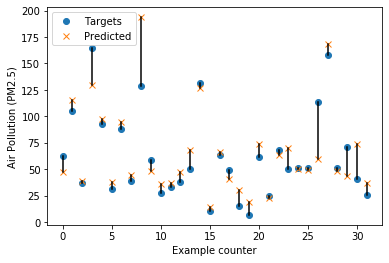

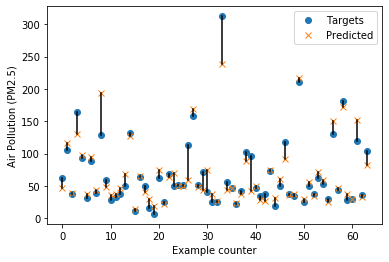

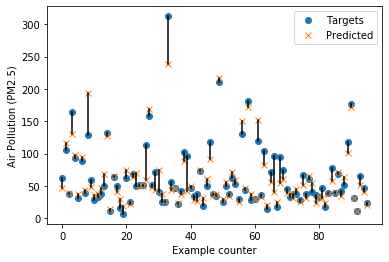

KeyError: '95'

In [49]:
        
path = 'result_models/lstm_nonulls_withmeta/'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)):
        files.append(os.path.join(path,i)) 
loadedModels = []
for file in files:
    lstmModel = NeuralNet(
                module=LSTMModel,
                module__inputDim = 6,
                module__hiddenDim = 121,
                module__seqLength = 121,
                module__numLayers = 2,
                module__batch_size=32,
                batch_size=32,
                criterion=torch.nn.L1Loss,
                optimizer=torch.optim.Adam,
                max_epochs=500,
                lr = 0.0001,
                device='cuda',
                iterator_train__shuffle=True,
                iterator_train__drop_last=True,
                iterator_valid__drop_last=True,
                train_split=predefined_split(validation_dataset),
                 callbacks=[
                    HiddenStateResetter(),
                    EarlyStoppingWaiter(),
                    EarlyStopping(patience=100)
                ]
            )    
    lstmModel.initialize()  # This is important!
    lstmModel.load_params(f_params=file)
    loadedModels.append(lstmModel)

results = evaluate_performance(loadedModels, train_dataset, validation_dataset, test_dataset)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# trainRes = []
# valRes = []
# testRes []
trainRMSE = []
valRMSE = []
testRMSE = []
trainMAE = []
valMAE = []
testMAE = []
for modelNum in results:
    trainRMSE.append(mean_squared_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valRMSE.append(mean_squared_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testRMSE.append(mean_squared_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
    trainMAE.append(mean_absolute_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valMAE.append(mean_absolute_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testMAE.append(mean_absolute_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
trainRMSE = np.sqrt(trainRMSE)
print(trainRMSE)
valRMSE = np.sqrt(valRMSE)
testRMSE = np.sqrt(testRMSE)
print("RMSE")
print("TrainRes: ", np.round(np.mean(trainRMSE), 2), " +- ", np.round(np.std(trainRMSE),2))
print("ValRes: ", np.round(np.mean(valRMSE), 2), " +- ", np.round(np.std(valRMSE),2))
print("TestRes: ", np.round(np.mean(testRMSE), 2), " +- ", np.round(np.std(testRMSE),2))
print("MAE")
print("TrainRes: ", np.round(np.mean(trainMAE), 2), " +- ", np.round(np.std(trainMAE),2))
print("ValRes: ", np.round(np.mean(valMAE), 2), " +- ", np.round(np.std(valMAE),2))
print("TestRes: ", np.round(np.mean(testMAE), 2), " +- ", np.round(np.std(testMAE),2))

# 
# r_square = r2_score(targetlist, predlist)

In [ ]:
predlist, targetlist = evaluate_performance(model)

# print(predlist)
# print(targetlist)
plt.bar([i for i, x in enumerate(predlist) ],abs(predlist-targetlist))
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

In [ ]:
l = lstmModel.history[:, 'train_loss']
v = lstmModel.history[:, 'valid_loss']
plt.clf()
plt.plot([i for i in range(len(l))], l, label='Train loss')
plt.plot([i for i in range(len(v))], v,  label='Valid loss')
plt.legend()
plt.show()

# Convolutional Neural Network

In [ ]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, kernel_size, outChan):
        super(TimeSeriesCNN, self).__init__()
        self.magicNumber = 48
        self.outChan = outChan
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=outChan, kernel_size=kernel_size)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(1,2))
        self.relu2 = nn.ReLU()
        if isUsingMetadata:
            self.hiddenOneHotDim = 60 #same as the LSTM dim
            self.linearOneHot = nn.Linear(5, self.hiddenOneHotDim) 
            self.fc1 = nn.Linear((outChan*self.magicNumber) + self.hiddenOneHotDim, 1)
            self.reluOneHot = nn.ReLU()
        else:
            self.fc1 = nn.Linear((outChan*self.magicNumber), 1)
    
#         self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, t):
        if isUsingMetadata:
            #t is a tensor with two cols, one for 
            oneHot = t[1]
            t = t[0]
            
        t = self.relu1(self.conv1(t)) 
        t = self.pool1(t)
        t = t.view(-1, self.outChan*self.magicNumber)

        if isUsingMetadata:
            oneHotOutput = self.reluOneHot(self.linearOneHot(oneHot))
            t = torch.cat((t, oneHotOutput), 1)
            
        t = self.fc1(t)
        t = self.relu2(t)
        return t.view(-1)


In [ ]:
batch_size = 100
channels = 1
height = 6
length = 121
kernel_size = (height, 25)

cnn = TimeSeriesCNN(kernel_size, 200).cuda()
# train_dataset[0][0].shape
x = torch.randn(batch_size, channels, height, length)
# cnn(x)
dltrain = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0, drop_last=True)

for i, (x,y) in enumerate(dltrain):
    res = cnn(x)
    print(res)
# print(x.shape)
# print(torch.unsqueeze(x, 1).shape)
# res = cnn(x)
# print(res)

In [ ]:
height = 6
experimentList = []

In [ ]:
from skorch.helper import predefined_split
outChannelList = [1024]
for outChan in outChannelList:
    for run in range(5):
        cnnModel = NeuralNet(
                    module=TimeSeriesCNN,
                    module__kernel_size = (height, 25),
                    module__outChan = outChan,
                    batch_size=32,
                    criterion=torch.nn.L1Loss,
                    optimizer=torch.optim.Adam,
                    max_epochs=500,
                    lr = 0.0001,
                    device='cuda',
                    iterator_train__shuffle=True,
                    iterator_train__drop_last=True,
                    iterator_valid__drop_last=True,
                    train_split=predefined_split(validation_dataset),
                     callbacks=[
            #                     EarlyStoppingWaiter(),
                        EarlyStopping(patience=10)
                    ]
            )
        cnnModel.fit(train_dataset)
        l = cnnModel.history[:, 'train_loss']
        v = cnnModel.history[:, 'valid_loss']
        experimentList.append({f"run_cnn_loss_removenulls_fmap{outChan}_run{run}" : {'train' : l, 'val' : v} })
        cnnModel.save_params(f_params=f"run_cnn_removenulls_exp_run{run}.pkl")

In [ ]:
import pickle
with open('runs_cnn_removenulls_experiments_withmetadata.pkl', 'wb') as f:
    pickle.dump(experimentList, f)

In [ ]:
for el in experimentList:
    for k in el:
#         print(k)
#         print(el[k]['val'])
        ind = k
#         k = k.replace('run_cnn_loss_imputed_fmap', '')
#         k= 'Feature Maps: ' + k
#         k = 'L:' + k
# #         k = k[:-3]
#         k = k.replace('b_', 'B:')
#         k = k.replace('n_', 'N:')
#         k = k[-3:]
        plt.plot(el[ind]['val'][:180], label = k)
# plt.axvline(x=100, color='k', linestyle='--', label='Early Stopping')
plt.legend()
plt.ylabel('Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.show()

In [ ]:
        
path = 'result_models/cnn_nonulls_withmeta/'
files = []
for i in os.listdir(path):
    if os.path.isfile(os.path.join(path,i)):
        files.append(os.path.join(path,i)) 
loadedModels = []
for file in files:
    cnnModel = NeuralNet(
                    module=TimeSeriesCNN,
                    module__kernel_size = (height, 25),
                    module__outChan = outChan,
                    batch_size=32,
                    criterion=torch.nn.L1Loss,
                    optimizer=torch.optim.Adam,
                    max_epochs=500,
                    lr = 0.0001,
                    device='cuda',
                    iterator_train__shuffle=True,
                    iterator_train__drop_last=True,
                    iterator_valid__drop_last=True,
                    train_split=predefined_split(validation_dataset),
                     callbacks=[
            #                     EarlyStoppingWaiter(),
                        EarlyStopping(patience=10)
                    ]
            )   
    cnnModel.initialize()  # This is important!
    cnnModel.load_params(f_params=file)
    loadedModels.append(cnnModel)

results = evaluate_performance(loadedModels, train_dataset, validation_dataset, test_dataset)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# trainRes = []
# valRes = []
# testRes []
trainRMSE = []
valRMSE = []
testRMSE = []
trainMAE = []
valMAE = []
testMAE = []
for modelNum in results:
    trainRMSE.append(mean_squared_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valRMSE.append(mean_squared_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testRMSE.append(mean_squared_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
    trainMAE.append(mean_absolute_error(results[modelNum]['trainRes']['targets'], results[modelNum]['trainRes']['predicted']))
    valMAE.append(mean_absolute_error(results[modelNum]['valRes']['targets'], results[modelNum]['valRes']['predicted']))
    testMAE.append(mean_absolute_error(results[modelNum]['testRes']['targets'], results[modelNum]['testRes']['predicted']))
trainRMSE = np.sqrt(trainRMSE)
print(trainRMSE)
valRMSE = np.sqrt(valRMSE)
testRMSE = np.sqrt(testRMSE)
print("RMSE")
print("TrainRes: ", np.round(np.mean(trainRMSE), 2), " +- ", np.round(np.std(trainRMSE),2))
print("ValRes: ", np.round(np.mean(valRMSE), 2), " +- ", np.round(np.std(valRMSE),2))
print("TestRes: ", np.round(np.mean(testRMSE), 2), " +- ", np.round(np.std(testRMSE),2))
print("MAE")
print("TrainRes: ", np.round(np.mean(trainMAE), 2), " +- ", np.round(np.std(trainMAE),2))
print("ValRes: ", np.round(np.mean(valMAE), 2), " +- ", np.round(np.std(valMAE),2))
print("TestRes: ", np.round(np.mean(testMAE), 2), " +- ", np.round(np.std(testMAE),2))

# 
# r_square = r2_score(targetlist, predlist)

# Outdated Code below

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from torch.utils.data.dataloader import default_collate

# class SliceDatasetX(Dataset):
#     """Helper class that wraps a torch dataset to make it work with sklearn"""
#     def __init__(self, dataset, collate_fn=default_collate):
#         self.dataset = dataset
#         self.collate_fn = collate_fn
#         self._indices = list(range(len(self.dataset)))
        
#     def __len__(self):
#         return len(self.dataset)
        
#     @property
#     def shape(self):
#         return len(self),
    
#     def __getitem__(self, i):
#         if isinstance(i, (int, np.integer)):
#             Xb = self.dataset[i][0]
#             return Xb
        
#         if isinstance(i, slice):
#             i = self._indices[i]

#         Xb = self.collate_fn([self.dataset[j][0] for j in i])
#         return Xb
    
# weather_dataset = WeatherDataset(dfCollection, dfCollectionTargets)
# y_from_ds = np.asarray([weather_dataset[i][1] for i in range(len(weather_dataset))])
# print(y_from_ds.shape)
# ds_sliceable = SliceDatasetX(weather_dataset)
# print(ds_sliceable.shape)
# print(y_from_ds[0])


In [ ]:
# params = {
#     'lr': [0.01, 0.02],
#     'max_epochs': [10, 20],
# #     'module__num_units': [10, 20],
# }

# gs = GridSearchCV(lstmModel, params, refit=False, cv=3, scoring='neg_mean_absolute_error')
# gs.fit(ds_sliceable, y_from_ds)
# print(gs.best_score_, gs.best_params_)


In [ ]:
# lstmModel.predict(weather_dataset.__getitem__(0))
# l = lstmModel.history[:, 'train_loss']
# v = lstmModel.history[:, 'valid_loss']
# print(v)
# plt.clf()
# plt.plot([i for i in range(len(l))], l, label='Train loss')
# plt.plot([i for i in range(len(v))], v,  label='Valid loss')
# plt.legend()
# plt.show()

## Training

In [ ]:
# batch_size = 32
# num_epochs = 500
# hidden_dimension = 121
# num_layers = 2 #todo add multiple layers with dropout
# lossesOverTime = []

In [ ]:
# weather_dataset = WeatherDataset(dfCollection, dfCollectionTargets)
# data_loader = torch.utils.data.DataLoader(weather_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
# model = LSTMModel(inputDim = 6, hiddenDim = hidden_dimension, seqLength = 121, numLayers = num_layers, batch_size=batch_size).cuda()
# # hiddenState = model.get_initial_hidden_state(batch_size=batch_size)

# loss_function = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# for epoch in tqdm(range(num_epochs)):
#     for i_batch, (x, y) in enumerate(data_loader):
#         x = Variable(x.float()).cuda()
#         y = Variable(y.float()).cuda()
# #         out, hiddenState = model(x, hiddenState)
#         model.reset_hidden_state() #batches are unrelated, and should have different states
#         out = model(x)
# #         hiddenState = repackage_hidden(hiddenState)        
#         model.zero_grad()
#         loss = loss_function(out, y)
#         if i_batch % 50 == 0: 
#             print(f"batch: {i_batch}, loss: {loss}\n predicted: {out} target: {y}")
#         lossesOverTime.append(loss.item())
#         loss.backward()
#         optimizer.step()

In [ ]:
# plt.plot(lossesOverTime)
# plt.show()

In [ ]:
# test_actual.head()